Part 1: Problem Description. 

Kaggle Challenge: Titanic: Machine Learning from Disaster.

Goal:
The task is to predict whether a given passenger survived the sinking of the Titanic based on various attributes including sex, age, location of the passenger's cabin on the ship, family members, the fare they paid, and other information. 

Evaluation: Solutions are evaluated by comparing the percentage of correct answers on a test dataset.


Part 2: Analysis Approach. Write a few sentences describing how you approached the problem. What techniques did you use? 


First I've calculate a baseline accuracy: I split the data by gender, discovered that female's survival rate is 0.78; male is 0.19. The baseline accuracy is created by predict male not survived, and female survived which gave us a <b> 0.78</b> accuracy.

I chose <b>randomforest</b> to train the model. I ignored Age, Cabin attributes since there are 20%, 70% missing values respectively.
I also added in few features, which are extracting from other dimensions: family size, if the passenger is alone, and the title from their name.

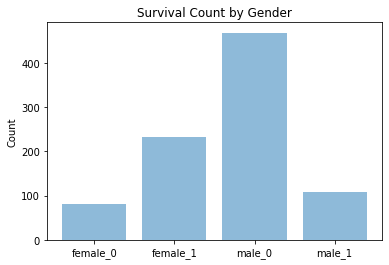

% of women who survived: 0.74
% of men who survived: 0.19


In [131]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

def basic_details(df):
    b = pd.DataFrame()
    b['Missing value, %'] = round(df.isnull().sum()/df.shape[0]*100)
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b

train_details = basic_details(train_data)
test_details = basic_details(test_data)


train_pivot = train_data[['Sex', 'Survived', 'Name']].groupby(['Sex', 'Survived']).count();
objects = [ x[0]+"_"+str(x[1]) for x in train_pivot.index]
y_pos = np.arange(len(objects))
performance = list(train_pivot['Name'].values)

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Survival Count by Gender')

plt.show()



women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)



print("% of women who survived: {:.2f}".format(rate_women))
print("% of men who survived: {:.2f}".format(rate_men))


In [132]:
x_train, x_test, y_train, y_test = train_test_split(train_data, train_data['Survived'], test_size=0.20, random_state=42)
predictions = x_test['Sex'].apply(lambda x: 1 if x=="female" else 0)
baseline_accuracy = accuracy_score(y_test, predictions)
print("Accuracy: {:.2f}".format(baseline_accuracy))

Accuracy: 0.78


In [133]:
print(train_details)
print(test_details)

             Missing value, %  N unique value    dtype
PassengerId               0.0             891    int64
Survived                  0.0               2    int64
Pclass                    0.0               3    int64
Name                      0.0             891   object
Sex                       0.0               2   object
Age                      20.0              88  float64
SibSp                     0.0               7    int64
Parch                     0.0               7    int64
Ticket                    0.0             681   object
Fare                      0.0             248  float64
Cabin                    77.0             147   object
Embarked                  0.0               3   object
             Missing value, %  N unique value    dtype
PassengerId               0.0             418    int64
Pclass                    0.0               3    int64
Name                      0.0             418   object
Sex                       0.0               2   object
Age       

Feature Engineering: adding in more dimension

In [134]:
# Creating a categorical variable for Family Sizes
train_data['FamilySize'] = ''
train_data['FamilySize'].loc[(train_data['SibSp'] <= 2)] = 'small'
train_data['FamilySize'].loc[(train_data['SibSp'] > 2) & (train_data['SibSp'] <= 5 )] = 'medium'
train_data['FamilySize'].loc[(train_data['SibSp'] > 5)] = 'large'

# Creating a categorical variable to tell if the passenger is alone
train_data['IsAlone'] = ''
train_data['IsAlone'].loc[((train_data['SibSp'] + train_data['Parch']) > 0)] = 'no'
train_data['IsAlone'].loc[((train_data['SibSp'] + train_data['Parch']) == 0)] = 'yes'

# Extracting the role they play in life, and group it in larger group
train_data['Title'] = train_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
train_data['Is_Married'] = 0
train_data['Is_Married'].loc[train_data['Title'] == 'Mrs'] = 1
train_data['Title'] = train_data['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
train_data['Title'] = train_data['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')


# Creating a categorical variable for Family Sizes
test_data['FamilySize'] = ''
test_data['FamilySize'].loc[(test_data['SibSp'] <= 2)] = 'small'
test_data['FamilySize'].loc[(test_data['SibSp'] > 2) & (test_data['SibSp'] <= 5 )] = 'medium'
test_data['FamilySize'].loc[(test_data['SibSp'] > 5)] = 'large'

# Creating a categorical variable to tell if the passenger is alone
test_data['IsAlone'] = ''
test_data['IsAlone'].loc[((test_data['SibSp'] + test_data['Parch']) > 0)] = 'no'
test_data['IsAlone'].loc[((test_data['SibSp'] + test_data['Parch']) == 0)] = 'yes'

# Extracting the role they play in life, and group it in larger group
test_data['Title'] = test_data['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
test_data['Is_Married'] = 0
test_data['Is_Married'].loc[test_data['Title'] == 'Mrs'] = 1
test_data['Title'] = test_data['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
test_data['Title'] = test_data['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

def get_feature_names(df):
    # Splitting the target
    target = df['Survived']
    # Dropping unused columns from the feature set
    df.drop(['PassengerId', 'Survived', 'Ticket', 'Name', 'Cabin'], axis=1, inplace=True)

    # Splitting categorical and numerical column dataframes
    categorical_df = df.select_dtypes(include=['object'])
    numeric_df = df.select_dtypes(exclude=['object'])

    # And then, storing the names of categorical and numerical columns.
    categorical_columns = list(categorical_df.columns)
    numeric_columns = list(numeric_df.columns)
    
    print("Categorical columns:\n", categorical_columns)
    print("\nNumeric columns:\n", numeric_columns)

    return target, categorical_columns, numeric_columns

target, categorical_columns, numeric_columns = get_feature_names(train_data)


Categorical columns:
 ['Sex', 'Embarked', 'FamilySize', 'IsAlone', 'Title']

Numeric columns:
 ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Is_Married']


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Part 3: Initial Solution. 

I first created an evaluation function, the calculate the accuracy of the model.
I split the data into train/test set to train the model, using randomforest from Skilearn package.


In [135]:
# function to evalulate our result
def evaluateModel(classifier, x_test, y_test):
    predictions = classifier.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: {:.2f}".format(accuracy))
    return accuracy


In [143]:
features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'Is_Married']
train_data_processed = pd.get_dummies(train_data[features])
x_train, x_test, y_train, y_test = train_test_split(train_data_processed, target, test_size=0.20, random_state=42)
y_train = y_train.to_numpy() # Transforming training targets into numpy arrays
y_test = y_test.to_numpy() # Transforming test targets into numpy arrays


model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(x_train, y_train)


random_forest_result = evaluateModel(model, x_test, y_test)
"{:.1f}% increase in accuracy".format(((random_forest_result-baseline_accuracy)/baseline_accuracy)*100)

Accuracy: 0.82


'5.0% increase in accuracy'

Part 4: Initial Solution Analysis. Write a few sentences assessing your approach. Did it work? What do you think the problems were?

My approach recived a 0.82 accuracy score, which has a 5% increse in accuracy.

Part 5: Revised Solution and Analysis. Write a few sentences describing how you improved on your solution, and whether or not it worked.

Next, I fill in the <b>missing value</b> for <b>"Age"</b> by using the <b>mean & median</b> of other people's age.
Both accuracy score increase 0.01 (0.68%)

In [147]:


features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'Is_Married']
train_data_processed = pd.get_dummies(train_data[features])
train_data_processed['Age'] = train_data_processed['Age'].fillna(-1)

imputer = SimpleImputer(missing_values=-1, strategy='mean')
train_data_processed.Age = imputer.fit_transform(train_data_processed['Age'].values.reshape(-1,1))[:,0]
train_data_processed.Age = imputer.fit_transform(train_data_processed['Age'].values.reshape(-1,1))[:,0]

x_train, x_test, y_train, y_test = train_test_split(train_data_processed, target, test_size=0.20, random_state=42)
y_train = y_train.to_numpy() # Transforming training targets into numpy arrays
y_test = y_test.to_numpy() # Transforming test targets into numpy arrays


model_age_mean = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model_age_mean.fit(x_train, y_train)


random_forest_result_age_mean = evaluateModel(model_age_mean, x_test, y_test)
"{:.2f}% increase in accuracy".format(((random_forest_result_age_mean-random_forest_result)/random_forest_result)*100)

Accuracy: 0.83


'0.68% increase in accuracy'

In [146]:


features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked', 'FamilySize', 'IsAlone', 'Title', 'Is_Married']
train_data_processed = pd.get_dummies(train_data[features])
train_data_processed['Age'] = train_data_processed['Age'].fillna(-1)

imputer = SimpleImputer(missing_values=-1, strategy='median')
train_data_processed.Age = imputer.fit_transform(train_data_processed['Age'].values.reshape(-1,1))[:,0]
train_data_processed.Age = imputer.fit_transform(train_data_processed['Age'].values.reshape(-1,1))[:,0]

x_train, x_test, y_train, y_test = train_test_split(train_data_processed, target, test_size=0.20, random_state=42)
y_train = y_train.to_numpy() # Transforming training targets into numpy arrays
y_test = y_test.to_numpy() # Transforming test targets into numpy arrays


model_age_median = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model_age_median.fit(x_train, y_train)


random_forest_result_age_median = evaluateModel(model_age_median, x_test, y_test)
"{:.2f}% increase in accuracy".format(((random_forest_result_age_median-random_forest_result)/random_forest_result)*100)

Accuracy: 0.83


'0.68% increase in accuracy'